In [32]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.nn.functional import sigmoid
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from scipy.stats import sem


### Load data

In [88]:
# keys to remove from origin _df.csv files
r_keys = ['GENDER', 'ETHNICITY_RACE_Asian', 'ETHNICITY_RACE_Black or African American', 'ETHNICITY_RACE_Hispanic/Latino', 
        'ETHNICITY_RACE_Other', 'ETHNICITY_RACE_Unknown/Not Reported', 'ETHNICITY_RACE_White', 'HIGHEST_ED_LEVEL_Associate/Bachelor degree',
       'HIGHEST_ED_LEVEL_Attended college/Technical school', 'HIGHEST_ED_LEVEL_Grade school (0-8)', 'HIGHEST_ED_LEVEL_High school (9-12) or GED',
       'HIGHEST_ED_LEVEL_Post-College graduate degree','PRIOR_TRANSPLANT', 'APT_AC',
       'BLEEDING_RK', 'CANCER_TYPES_YN','HEALTH_STATUS', 'HSTE_TYPES_YN',
       'HTN_LIV', 'LVEF_REC', 'PKD', 'PVP_TYPES_YN', 'SMOKER', 'BLOOD_TYPE_A',
       'BLOOD_TYPE_AB', 'BLOOD_TYPE_B', 'BLOOD_TYPE_O', 'CMV_RESULTS', 'CPRA',
       'CREATININE', 'EBV_RESULTS', 'HBV_ANTIBODY_TOT_RESULTS',
       'HBV_ANTIGEN_RESULTS', 'HBV_CORE_ANTIBODY_RESULTS', 'HCT',
       'HCV_ANTIBODY_RESULTS', 'HEMOGLOBIN','PLATELET_CNT']

d_keys = ['d_GENDER', 'd_ETHNICITY_RACE_American Indian or Alaska Native', 'd_ETHNICITY_RACE_Asian', 'd_ETHNICITY_RACE_Black or African American',
       'd_ETHNICITY_RACE_Hispanic/Latino', 'd_ETHNICITY_RACE_Native Hawaiian or Other Pacific Islander','d_ETHNICITY_RACE_White', 
       'd_CREATININE', 'd_HCT', 'd_HEMOGLOBIN', 'd_INR', 'd_PLATELET_CNT', 'dd_CMV_RESULTS', 'dd_DEATH_CAUSE_Anoxia/Cardiac', 
       'dd_DEATH_CAUSE_CNS Tumor', 'dd_DEATH_CAUSE_Cerebrovascular/Stroke', 'dd_DEATH_CAUSE_Head Trauma',
       'dd_DEATH_CAUSE_Other', 'dd_DONATION_DCD',  'dd_EBV_RESULTS', 'dd_HBV_ANTIGEN_RESULTS',
       'dd_HBV_CORE_ANTIBODY_RESULTS', 'dd_HEP_C_ANTIBODY_STATUS',
       'dd_HEP_RNA_STATUS', 'dd_HIV_RESULTS', 'dd_DONOR_INTEST_PROCURED', 'dd_DONOR_PANC_PROCURED'
]

op_keys= ['ARTERIES_RENAL_ALLOGRAFT', 'GRAFT_TYPE_KID', 'NUM_RENAL_VEINS', 'NUM_URETERS',
       'MFOUTSLUSH_KIDNEYREPERF', 'BLADDER_TECHNIQUE_Neobladder or Ileal loop',
       'BLADDER_TECHNIQUE_Ureteroneocystotomy',
       'BLADDER_TECHNIQUE_Ureteropyelostomy',
       'BLADDER_TECHNIQUE_Ureteroureterostomy', 'PRBC_UNITS',]

c_keys = ['losGT5', 'CARDIAC_CPR', 'DEEPINC_SSI',
       'SUPERFICIALINC_SSI', 'ORGANSPACE_SSI', 'WOUND_DISRUPTION','PNEUMONIA', 'PULMONARYEMBOLISM', 'SEPSIS', 'SEPTICSHOCK', 'UTI',
       'VEIN_THROMBOSIS',  'DISCHARGE_DESTINATION_Facility which was home',
       'DISCHARGE_DESTINATION_Home', 'DISCHARGE_DESTINATION_Rehab',
       'DISCHARGE_DESTINATION_Skilled care, not home',
       'DISCHARGE_DESTINATION_Unskilled facility, not home', ]

# Load data
base_path = os.getcwd()
data_path = os.path.join(base_path, 'data')
filename = os.path.join(data_path, 'filtered_encoded_recipient_donor_op_comp.csv')

data = pd.read_csv(filename)

print(f"Total number of features (in_feature): {len(data.columns.drop(['CASEID', 'readm30daydc']))}\n")
print(f"Total number of patients: {len(data)}\n")
print(data.columns)
#display(data.head())


Total number of features (in_feature): 43

Total number of patients: 2354

Index(['Unnamed: 0', 'CASEID', 'AGE_TSRF', 'BMI_TSRF', 'BMIcat_Morbidly Obese',
       'BMIcat_Normal', 'BMIcat_Obese', 'BMIcat_Overweight',
       'BMIcat_Underweight', 'EMPLOYMENT_STATUS',
       'PRIMARY_INSURANCE_Government/Other', 'PRIMARY_INSURANCE_Private',
       'PRIMARY_INSURANCE_Unknown', 'CARDIAC_REVASC', 'DIABETES_REC',
       'DIALYSIS_Hemodialysis', 'DIALYSIS_Not on dialysis',
       'DIALYSIS_Peritoneal dialysis', 'HIV_RESULTS', 'INR', 'd_AGE_TSRF',
       'd_BMI_TSRF', 'd_BMIcat_Morbidly Obese', 'd_BMIcat_Normal',
       'd_BMIcat_Obese', 'd_BMIcat_Overweight', 'd_BMIcat_Underweight',
       'd_BLOOD_TYPE_A', 'd_BLOOD_TYPE_AB', 'd_BLOOD_TYPE_B', 'd_BLOOD_TYPE_O',
       'KDPI', 'KDPI.85', 'dd_HTN_DEC', 'dd_DIABETES_DON', 'dd_DONOR_BIOPSY',
       'dd_PULSATILE_PERFUSION', 'INTRAOP_URETERAL_STENT', 'CIT',
       'PRBC_UNITSINC', 'MFOP_OP_END', 'MI', 'VENTILATOR', 'DFOP_HOSPDISCH',
       'readm30

### Prepare data

In [74]:
# Define MLP model
class MLP1(nn.Module):
    def __init__(self, input_dim: int = 56, dropout_p = 0.0):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,75),
            nn.ReLU(),
            nn.Linear(75,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x
    


In [75]:
scaler = StandardScaler()
X = data.drop(columns=['CASEID', 'readm30daydc']).values.astype(np.float32)
X = scaler.fit_transform(X)
y = data['readm30daydc'].values.astype(np.float32)

class_weight = torch.tensor([sum(y==0)/sum(y==1)])
print(class_weight)

tensor([3.0586], dtype=torch.float64)



==================== Fold 1 ====================
Epoch [1/10], Training Loss: 1.963 Validation Loss: 2.009
Epoch [10/10], Training Loss: 1.605 Validation Loss: 1.993
0.47602448 0.4325208 0.007931998
Fold 1 AUROC: 0.61
Fold 1 Test Accuracy: 24.6%

==================== Fold 2 ====================
Epoch [1/10], Training Loss: 2.081 Validation Loss: 2.215
Epoch [10/10], Training Loss: 1.704 Validation Loss: 2.192
0.5501475 0.5103113 0.005338918
Fold 2 AUROC: 0.59
Fold 2 Test Accuracy: 24.6%

==================== Fold 3 ====================
Epoch [1/10], Training Loss: 2.138 Validation Loss: 2.017
Epoch [10/10], Training Loss: 1.774 Validation Loss: 1.996
0.48842627 0.43636948 0.006712265
Fold 3 AUROC: 0.62
Fold 3 Test Accuracy: 24.6%

==================== Fold 4 ====================
Epoch [1/10], Training Loss: 2.165 Validation Loss: 2.253
Epoch [10/10], Training Loss: 1.782 Validation Loss: 2.205
0.5684925 0.5035924 0.0080458
Fold 4 AUROC: 0.61
Fold 4 Test Accuracy: 24.6%

==============

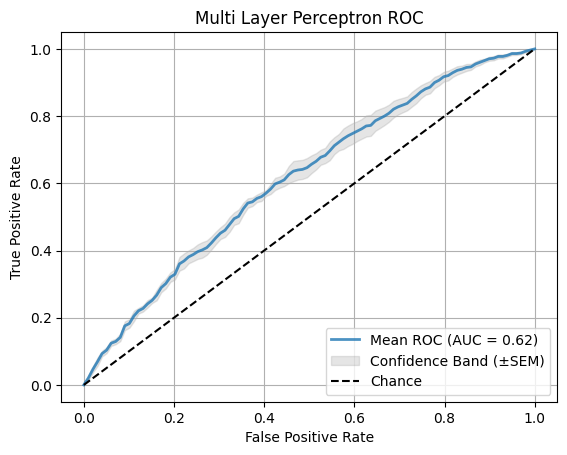

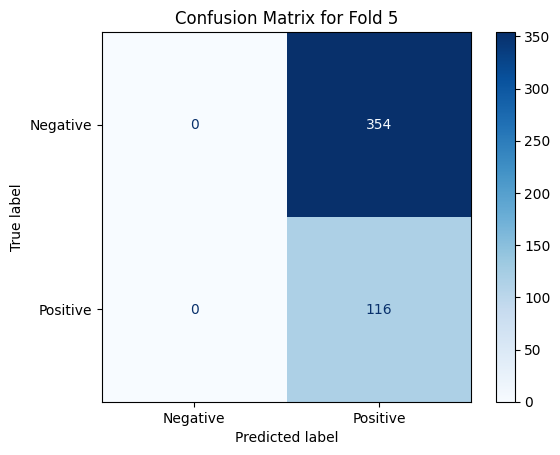

Mean AUROC: 0.617
95% Confidence Interval: [0.594, 0.641]
Interquartile Range (IQR): [0.606, 0.619]


In [87]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_results = {}
all_fprs = []
all_tprs =[]
aucs = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):

    print(f'\n{"="*20} Fold {fold} {"="*20}')
    
    # Split data
    X_train_fold, X_test_fold = torch.tensor(X[train_index]), torch.tensor(X[test_index])
    y_train_fold, y_test_fold = torch.tensor(y[train_index]).unsqueeze(1), torch.tensor(y[test_index]).unsqueeze(1)
    
    # Initialize model
    in_features = X.shape[1]
    model = MLP1(in_features)

    # Loss and optimizer
    # Use BCEWithLogitsLoss for numerical stability and apply class weights
    criterion = nn.BCELoss(weight=class_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=5)

    # Training loop
    num_epochs = 10
    training_loss = []
    validation_loss = []

    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        outputs = model(X_train_fold)
        train_loss = criterion(outputs, y_train_fold)

        training_loss.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            outputs = model(X_test_fold)
            test_loss = criterion(outputs, y_test_fold)
            validation_loss.append(test_loss.item())

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss.item():.3f} Validation Loss: {test_loss.item():.3f}")
        
        scheduler.step(test_loss)  # Pass validation loss to scheduler
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_fold)
        loss = criterion(outputs, y_test_fold)
        y_prob = outputs.squeeze().numpy()
        print(max(y_prob), min(y_prob), np.std(y_prob))
        y_pred = (y_prob >= 0.0001).astype(int)
        y_true = y_test_fold.squeeze().numpy().astype(int)

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    all_fprs.append(fpr)
    all_tprs.append(np.interp(np.linspace(0, 1, 100), fpr, tpr))
    all_tprs[-1][0] = 0.0  # Ensure starting point is zero

    print(f"Fold {fold} AUROC: {roc_auc:.2f}")

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Fold {fold} Test Accuracy: {accuracy*100:.1f}%")
    #print(y_pred)
    fold_results[fold] = {
        "accuracy": accuracy,
        "roc_auc": roc_auc
    }

# Mean ROC Curve and Confidence Interval
mean_tpr = np.mean(all_tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure end point is 1.0
mean_auc = auc(np.linspace(0, 1, 100), mean_tpr)
std_auc = np.std(aucs)

tprs_upper = np.minimum(mean_tpr + sem(all_tprs, axis=0), 1)
tprs_lower = np.maximum(mean_tpr - sem(all_tprs, axis=0), 0)

plt.plot(np.linspace(0, 1, 100), mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.2f})", lw=2, alpha=0.8)
plt.fill_between(np.linspace(0, 1, 100), tprs_lower, tprs_upper, color="grey", alpha=0.2, label="Confidence Band (±SEM)")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi Layer Perceptron ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Labels are optional for binary classification
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')  # Customize the color map if needed
plt.title(f"Confusion Matrix for Fold {fold}")
plt.show()

# Calculate mean, SEM, and confidence intervals
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
sem_auc = sem(aucs)
ci_lower = mean_auc - 1.96 * sem_auc
ci_upper = mean_auc + 1.96 * sem_auc

# Calculate IQR
q1 = np.percentile(aucs, 25)
q3 = np.percentile(aucs, 75)
iqr_auc = q3 - q1

# Print results
print(f"Mean AUROC: {mean_auc:.3f}")
print(f"95% Confidence Interval: [{ci_lower:.3f}, {ci_upper:.3f}]")
print(f"Interquartile Range (IQR): [{q1:.3f}, {q3:.3f}]")